# Nome: Rafael Gonçalves

## Imports

In [0]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import re
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

torch.manual_seed(0)

## Download dataset

In [0]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

File ‘imdb_sample.tgz’ already there; not retrieving.



In [0]:
df = pd.read_csv('imdb_sample/texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [0]:
df_train = df[df['is_valid'] == False]
df_val = df[df['is_valid'] == True]
print("Train data:", df_train.shape)
print("Validation data:", df_val.shape)

Train data: (800, 3)
Validation data: (200, 3)


## Create dataset (BoW + DataLoader)

In [0]:
corpus = list(df_train['text'])
corpus_val = list(df_val['text'])

In [0]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [0]:
# Create doc-trm matrixes
cv = CountVectorizer(stop_words=stop_words, max_features=10000) # Arbitrary number
doc_term = cv.fit_transform(corpus).todense()
doc_term_val = cv.transform(corpus_val).todense()
n_params = doc_term.shape[1]

In [0]:
# Scale input params into the range (0, 1)
scaler = MinMaxScaler()
doc_term = scaler.fit_transform(doc_term)
doc_term_val = scaler.transform(doc_term_val)

In [0]:
# Create label vectors
label = np.array([1 if (e == 'positive') else 0 for e in df_train['label'].to_numpy()])
label_val = np.array([1 if (e == 'positive') else 0 for e in df_val['label'].to_numpy()])

In [0]:
# Adjust data formats
x_t, x_t_v, y_t, y_t_v = map(lambda x: torch.from_numpy(x), [doc_term, doc_term_val, label, label_val])
x_tf, x_tf_v = x_t.type(torch.float32), x_t_v.type(torch.float32)
y_tf, y_tf_v = y_t.type(torch.float32), y_t_v.type(torch.float32)

print('shape x = ', x_tf.shape, x_tf.dtype, '\nshape x_val =', x_tf_v.shape, x_tf_v.dtype)
print('shape y = ', y_tf.shape, y_tf.dtype, '\nshape y_val =', y_tf_v.shape, y_tf_v.dtype)

shape x =  torch.Size([800, 10000]) torch.float32 
shape x_val = torch.Size([200, 10000]) torch.float32
shape y =  torch.Size([800]) torch.float32 
shape y_val = torch.Size([200]) torch.float32


In [0]:
# Create pytorch dataloader to facilitate training process
train_dataset = torch.utils.data.TensorDataset(x_tf, y_tf)
mini_train_dataset = torch.utils.data.Subset(train_dataset, range(len(train_dataset)//2))
test_dataset = torch.utils.data.TensorDataset(x_tf_v, y_tf_v)

# Solution

In [0]:
# Use GPU acceleration
use_cuda = True
device = 'cuda' if (use_cuda and torch.cuda.is_available()) else 'cpu'
device

'cuda'

## Implementing neural net model

In [0]:
class Model(torch.nn.Module):
  """ MLP model with number of neurons in input, hidden layers and
  output layers defined by the list layers. Activation is given by
  rectified linear function. Output is in the form of logits."""

  def __init__(self, layers):
    super(Model, self).__init__()
    self.layers = torch.nn.ModuleList(
        [torch.nn.Linear(n_in, n_out) for (n_in, n_out) in zip(layers[:-1], layers[1:])])

  def forward(self, x):
    for layer in self.layers[:-1]:
      x = layer(x)
      x = torch.nn.functional.relu(x)
    x = self.layers[-1](x).flatten()
    return x

In [0]:
def train(epoch, model, optimizer, criterion=torch.nn.BCEWithLogitsLoss(), v=False):
  """Training routine for model."""
  model.train()
  train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    y_logits = model(data)
    loss = criterion(y_logits, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    if v:
      print('\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch_idx - 1) * train_loader.batch_size + len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  train_loss /= len(train_loader)

  return train_loss

In [0]:
def test(epoch, model, optimizer, criterion=torch.nn.BCEWithLogitsLoss(), v=True):
  """Testing routine for model."""
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data = data.to(device)
      target = target.to(device)
      y_logits = model(data)
      loss = criterion(y_logits, target)
      test_loss += loss.item()
      pred = torch.round(torch.sigmoid(y_logits))
      correct += target.eq(pred).sum()
  test_loss /= len(test_loader)

  if v:
      print('\nTest set - epoch {}: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
      epoch, test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

  return test_loss, correct.item()/len(test_loader.dataset)

### Test if model and training are working

In [0]:
# Create mini train dataset for faster training for testing model choosing hyperparameters
train_loader = torch.utils.data.DataLoader(mini_train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2, pin_memory=True)

In [0]:
# Example model
model = Model([n_params, 50, 1]).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=10000, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [0]:
# Train-test loop
test(0, model, opt)
train_loss_l = []
test_loss_l = []
acc_l = []
for epoch in range(1, 20):
  train_loss = train(epoch, model, opt)
  test_loss, acc = test(epoch, model, opt, v = True)
  train_loss_l.append(train_loss)
  test_loss_l.append(test_loss)
  acc_l.append(acc)
test(epoch, model, opt)


Test set - epoch 0: Loss: 0.6946, Accuracy: 92/200 (46%)

Test set - epoch 1: Loss: 0.6920, Accuracy: 112/200 (56%)

Test set - epoch 2: Loss: 0.6881, Accuracy: 107/200 (54%)

Test set - epoch 3: Loss: 0.6815, Accuracy: 107/200 (54%)

Test set - epoch 4: Loss: 0.6683, Accuracy: 109/200 (54%)

Test set - epoch 5: Loss: 0.6421, Accuracy: 119/200 (60%)

Test set - epoch 6: Loss: 0.5935, Accuracy: 149/200 (74%)

Test set - epoch 7: Loss: 0.5379, Accuracy: 152/200 (76%)

Test set - epoch 8: Loss: 0.5043, Accuracy: 152/200 (76%)

Test set - epoch 9: Loss: 0.5058, Accuracy: 154/200 (77%)

Test set - epoch 10: Loss: 0.5434, Accuracy: 154/200 (77%)

Test set - epoch 11: Loss: 0.6143, Accuracy: 152/200 (76%)

Test set - epoch 12: Loss: 0.7010, Accuracy: 153/200 (76%)

Test set - epoch 13: Loss: 0.7953, Accuracy: 152/200 (76%)

Test set - epoch 14: Loss: 0.8922, Accuracy: 154/200 (77%)

Test set - epoch 15: Loss: 0.9845, Accuracy: 153/200 (76%)

Test set - epoch 16: Loss: 1.0713, Accuracy: 153/2

(1.2937573194503784, 0.755)

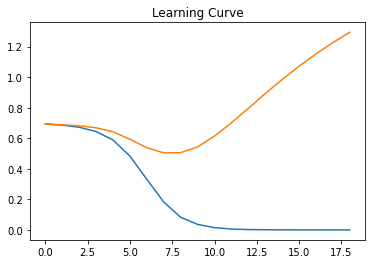

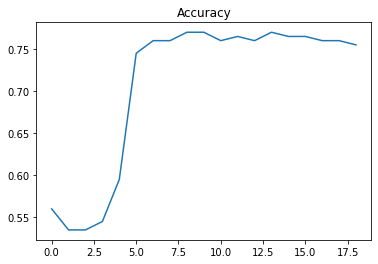

In [0]:
# Visualization of learning curves and accuracy
plt.plot(train_loss_l)
plt.plot(test_loss_l)
plt.title('Learning Curve')
plt.show()
plt.plot(acc_l)
plt.title('Accuracy')
plt.show()

### Experimenting with hyperparameters


#### SGD with momentum

In [0]:
# Hyperparameters
hidden_layer_params = [[], [50], [100], [500], [1000], [5000], [50, 10], [100, 50], [500, 50], [500, 100]]
learning_rate_params = [0.006, 0.01, 0.03, 0.06, 0.1, 0.3]
momentum_params = [0, 0.5, 0.9, 0.99]
epochs = 15

In [0]:
for hidden in hidden_layer_params:

  best_loss = 999

  layers = [n_params, *hidden, 1]

  for lr in learning_rate_params:
    for momentum in momentum_params:
      model = Model(layers).to(device)
      opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

      for epoch in range(1, epochs-1):
        train(epoch, model, opt)
        loss, acc = test(epoch, model, opt, v=False)
        if (loss < best_loss):
          best_loss, best_acc, best_lr, best_momentum, best_epoch = loss, acc, lr, momentum, epoch

  print("Best model with layers {}\nloss: {:.4f}, accuracy: {}, epoch: {}, lr: {}, momentum: {}\n".format(
      layers, best_loss, best_acc, best_epoch, best_lr, best_momentum))

Best model with layers [10000, 1]
loss: 0.4776, accuracy: 0.79, epoch: 5, lr: 0.06, momentum: 0.99

Best model with layers [10000, 50, 1]
loss: 0.4939, accuracy: 0.785, epoch: 8, lr: 0.01, momentum: 0.99

Best model with layers [10000, 100, 1]
loss: 0.4887, accuracy: 0.79, epoch: 2, lr: 0.3, momentum: 0.9

Best model with layers [10000, 500, 1]
loss: 0.4757, accuracy: 0.77, epoch: 2, lr: 0.3, momentum: 0.9

Best model with layers [10000, 1000, 1]
loss: 0.4821, accuracy: 0.78, epoch: 6, lr: 0.06, momentum: 0.9

Best model with layers [10000, 5000, 1]
loss: 0.4845, accuracy: 0.78, epoch: 12, lr: 0.006, momentum: 0.99

Best model with layers [10000, 50, 10, 1]
loss: 0.4872, accuracy: 0.77, epoch: 4, lr: 0.06, momentum: 0.99

Best model with layers [10000, 100, 50, 1]
loss: 0.4834, accuracy: 0.775, epoch: 11, lr: 0.01, momentum: 0.99

Best model with layers [10000, 500, 50, 1]
loss: 0.4908, accuracy: 0.77, epoch: 10, lr: 0.03, momentum: 0.9

Best model with layers [10000, 500, 100, 1]
loss

#### ADAM

In [0]:
# Hyperparameters
hidden_layer_params = [[], [50], [100], [500], [1000], [5000], [50, 10], [100, 50], [500, 50], [500, 100]]
learning_rate_params = [0.0006, 0.001, 0.003, 0.006, 0.01]
epochs = 15

In [0]:
for hidden in hidden_layer_params:

  best_loss = 999

  layers = [n_params, *hidden, 1]

  for lr in learning_rate_params:
    model = Model(layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs-1):
      train(epoch, model, opt)
      loss, acc = test(epoch, model, opt, v=False)
      if (loss < best_loss):
        best_loss, best_acc, best_lr, best_epoch = loss, acc, lr, epoch

  print("Best model with layers {}\nloss: {:.4}, accuracy: {}, epoch: {}, lr: {}\n".format(
      layers, best_loss, best_acc, best_epoch, best_lr))

Best model with layers [10000, 1]
loss: 0.5146, accuracy: 0.76, epoch: 13, lr: 0.006

Best model with layers [10000, 50, 1]
loss: 0.4833, accuracy: 0.775, epoch: 2, lr: 0.006

Best model with layers [10000, 100, 1]
loss: 0.4976, accuracy: 0.75, epoch: 1, lr: 0.006

Best model with layers [10000, 500, 1]
loss: 0.492, accuracy: 0.77, epoch: 3, lr: 0.001

Best model with layers [10000, 1000, 1]
loss: 0.4984, accuracy: 0.775, epoch: 3, lr: 0.0006

Best model with layers [10000, 5000, 1]
loss: 0.4819, accuracy: 0.785, epoch: 2, lr: 0.0006

Best model with layers [10000, 50, 10, 1]
loss: 0.5225, accuracy: 0.73, epoch: 1, lr: 0.01

Best model with layers [10000, 100, 50, 1]
loss: 0.5368, accuracy: 0.74, epoch: 1, lr: 0.006

Best model with layers [10000, 500, 50, 1]
loss: 0.5031, accuracy: 0.775, epoch: 4, lr: 0.0006

Best model with layers [10000, 500, 100, 1]
loss: 0.5342, accuracy: 0.725, epoch: 3, lr: 0.0006



### Training best models of each category

In [0]:
# Full dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2, pin_memory=True)

#### 1-layer MLP

In [0]:
model = Model([n_params, 1]).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.99)
epochs = 15

In [0]:
loss_l, loss_val_l, acc_l = [], [], []
best_loss = 999
best_acc = 0
for epoch in range(epochs):
  loss_train = train(epoch, model, opt)
  loss, acc = test(epoch, model, opt, v=False)
  loss_l.append(loss_train)
  loss_val_l.append(loss)
  acc_l.append(acc)
  if (loss < best_loss):
    best_epoch = epoch
    best_loss = loss
    best_acc = acc
  if (acc > best_acc):
    best_acc = acc
    best_epoch_a = epoch
print(best_epoch_a, best_acc)

8 0.82


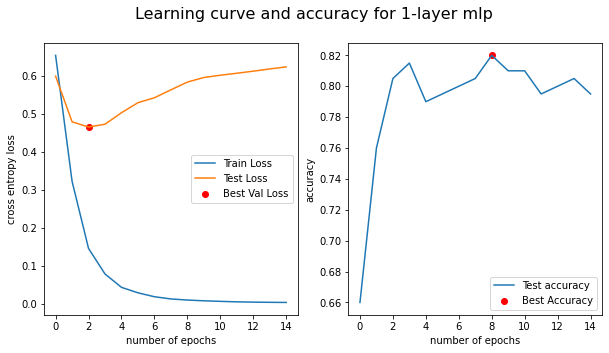

In [0]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(loss_l)
plt.plot(loss_val_l)
plt.scatter(best_epoch, best_loss, color="red")
plt.legend(['Train Loss', 'Test Loss', 'Best Val Loss'])
plt.xlabel('number of epochs')
plt.ylabel('cross entropy loss')

plt.subplot(1, 2, 2)
plt.plot(acc_l)
plt.scatter(best_epoch_a, best_acc, color='red')
plt.legend(['Test accuracy', 'Best Accuracy'])
plt.xlabel('number of epochs')
plt.ylabel('accuracy')


plt.suptitle('Learning curve and accuracy for 1-layer mlp', fontsize=16)
plt.show()

### 2-layer MLP

In [0]:
model = Model([n_params, 100, 1]).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
epochs = 15

In [0]:
loss_l, loss_val_l, acc_l = [], [], []
best_loss = 999
best_acc = 0
for epoch in range(epochs):
  loss_train = train(epoch, model, opt)
  loss, acc = test(epoch, model, opt, v=False)
  loss_l.append(loss_train)
  loss_val_l.append(loss)
  acc_l.append(acc)
  if (loss < best_loss):
    best_epoch = epoch
    best_loss = loss
    best_acc = acc
  if (acc > best_acc):
    best_acc = acc
    best_epoch_a = epoch
print(best_epoch_a, best_acc)

8 0.815


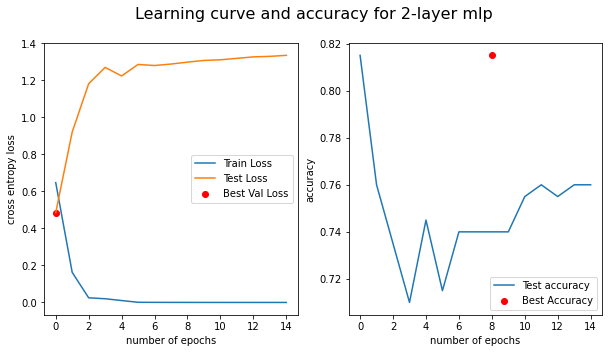

In [0]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(loss_l)
plt.plot(loss_val_l)
plt.scatter(best_epoch, best_loss, color="red")
plt.legend(['Train Loss', 'Test Loss', 'Best Val Loss'])
plt.xlabel('number of epochs')
plt.ylabel('cross entropy loss')

plt.subplot(1, 2, 2)
plt.plot(acc_l)
plt.scatter(best_epoch_a, best_acc, color='red')
plt.legend(['Test accuracy', 'Best Accuracy'])
plt.xlabel('number of epochs')
plt.ylabel('accuracy')


plt.suptitle('Learning curve and accuracy for 2-layer mlp', fontsize=16)
plt.show()

### 3-layer MLP

In [0]:
model = Model([n_params, 500, 100, 1]).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.006, momentum=0.99)
epochs = 15

In [0]:
loss_l, loss_val_l, acc_l = [], [], []
best_loss = 999
best_acc = 0
for epoch in range(epochs):
  loss_train = train(epoch, model, opt)
  loss, acc = test(epoch, model, opt, v=False)
  loss_l.append(loss_train)
  loss_val_l.append(loss)
  acc_l.append(acc)
  if (loss < best_loss):
    best_epoch = epoch
    best_loss = loss
    best_acc = acc
  if (acc > best_acc):
    best_acc = acc
    best_epoch_a = epoch
print(best_epoch_a, best_acc)

8 0.8


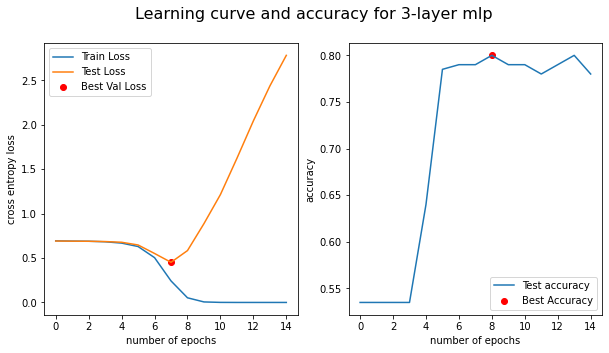

In [0]:
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(loss_l)
plt.plot(loss_val_l)
plt.scatter(best_epoch, best_loss, color="red")
plt.legend(['Train Loss', 'Test Loss', 'Best Val Loss'])
plt.xlabel('number of epochs')
plt.ylabel('cross entropy loss')

plt.subplot(1, 2, 2)
plt.plot(acc_l)
plt.scatter(best_epoch_a, best_acc, color='red')
plt.legend(['Test accuracy', 'Best Accuracy'])
plt.xlabel('number of epochs')
plt.ylabel('accuracy')


plt.suptitle('Learning curve and accuracy for 3-layer mlp', fontsize=16)
plt.show()

# End of Notebook